# Test de création d'une ondelette 3D
***

In [1]:
%pylab inline
from pywavan import fbm2d, powspec, fan_trans
from astropy.io import fits
import aplpy
from pywavan import nb_scale
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [2]:
from turbustat.simulator import make_3dfield, make_ppv
import astropy.units as u

***
# Création d'un cube de données

In [40]:
fbm3d_turbu = make_3dfield(64, powerlaw=3., randomseed = 162056701)

Ici le cube fait 64×64×64 pixel pour réduire le temps de calcul (environt 1 min par cube)   
Pour une meilleur vue des artefact il est parfois utile d'augmenter la taille du cube à 256×256×256. Dans ce cas le temps de calcul pour les étapes de ségmentation est d'environt 2h par cube 

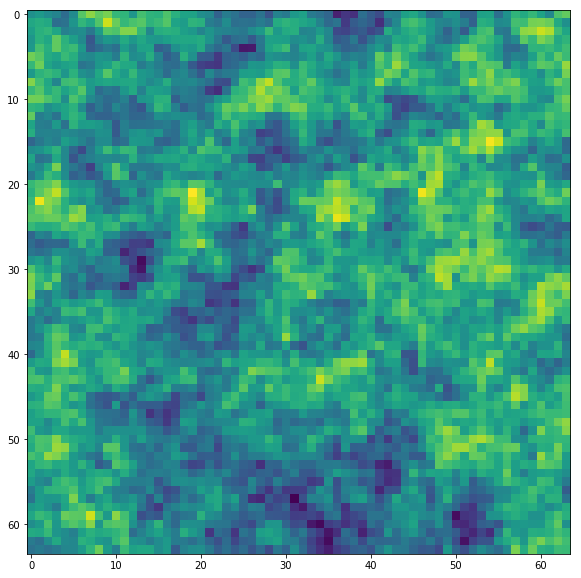

In [41]:
figure(figsize(10,10))
imshow(fbm3d_turbu[20,:,:])

In [42]:
fbm3d_turbu.shape

(64, 64, 64)

***
# Observation dans le plan UV pour un seul $\theta$ et un seul $\phi$

In [43]:
nx = fbm3d_turbu.shape[0]
ny = fbm3d_turbu.shape[1]
nz = fbm3d_turbu.shape[2]

In [44]:
ko= 5.336
a = 25.
delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet
t = 0.
ph = delta*5

x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

#rr = (xx**2 + yy**2 + zz**2)**0.5

uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))

uvsh = np.fft.ifftshift(uv)
wav3dsh = np.fft.irfftn(uvsh,s=uv.shape)

wav3d = np.fft.fftshift(wav3dsh)


In [45]:
wav3d.shape

(64, 64, 64)

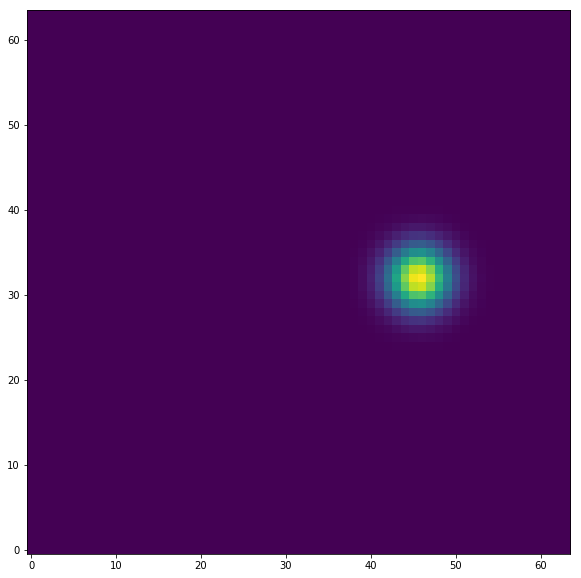

In [46]:
imshow(uv[int(nx/2),:,:],origin="lower")

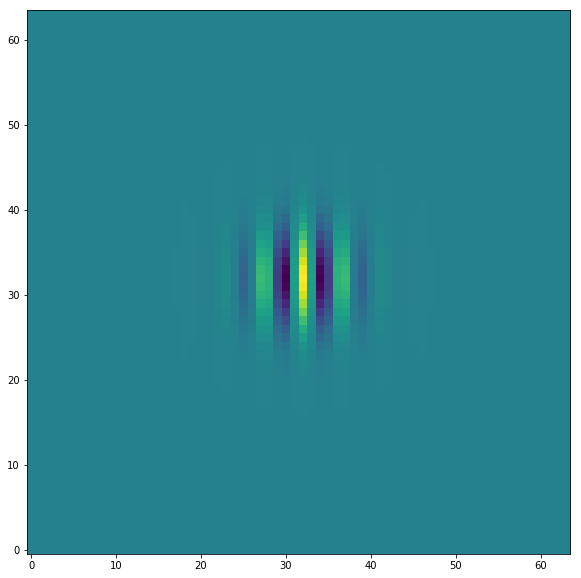

In [47]:
imshow(wav3d[int(nx/2),:,:],origin="lower")

In [ ]:
fits.writeto('/user/workdir/soldanof/3Dwavelet/gauss3d_b.fits',uv, overwrite= True)
fits.writeto('/user/workdir/soldanof/3Dwavelet/wavelet3d_b.fits',wav3d, overwrite= True)

***
# Première idée : $\theta$ et $\phi$ de 0 à $\pi$
## Observation du plan UV en 3D

In [6]:
nx = 64
ny = 64
nz = 64

In [50]:
ko= 5.336
a = 25.

delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

uv_t = np.zeros((nx,ny,nz))

for i in trange(N+1) :
    t=float(delta*i)
    for j in range(N+1):
        
        ph=float(delta*j)
        uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z- ko*np.cos(t))**2))
        uv_t= uv_t+ uv

100%|██████████| 12/12 [00:01<00:00,  7.42it/s]


Text(0.5, 1.0, '3')

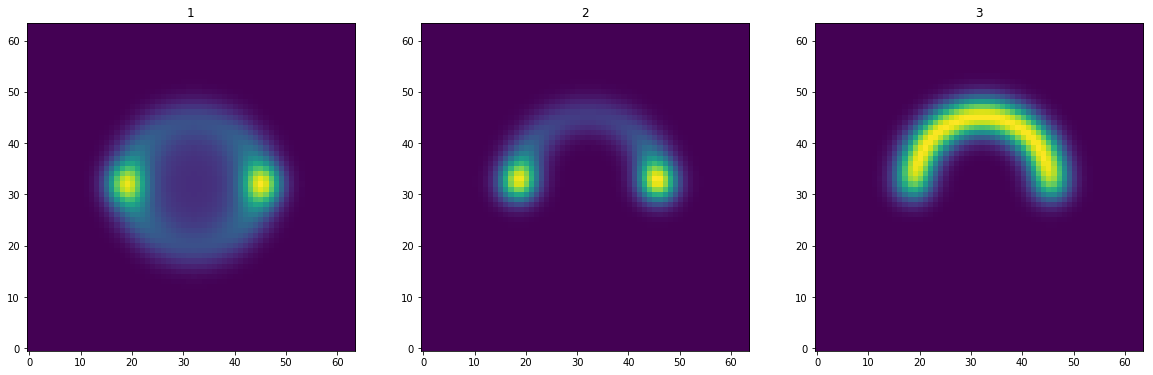

In [51]:
figure(figsize=(20,10))
subplot(131)
imshow(np.sum(uv_t, axis = 0),origin="lower")
title("1")

subplot(132)
imshow(uv_t[:,int(ny/2),:],origin="lower")
title("2")

subplot(133)
imshow(uv_t[:,:,int(nz/2)],origin="lower")
title("3")

On observe deux point très brillant sur le bord, surement dû à un sur-échantillonage de ces points.  

## Test de reconstruction

In [56]:
nx = fbm3d_turbu.shape[0]
ny = fbm3d_turbu.shape[1]
nz = fbm3d_turbu.shape[2]
reso=1
#fbm3d_turbu -= np.mean(fbm3d_turbu)
ko= 5.336
delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

#-----echelle a-----
nmax = np.max(np.array([nx,ny,nz]))
M=int(np.log(nmax)/delta)
a2=np.zeros(M)
a2[0]=np.log(nx)

for i in range(M-1):
    a2[i+1]=a2[i]-delta

a2=np.exp(a2)
wav_k = 1. / (a2 * reso)
a = ko * a2    #Scales in the wavelet space
#---------uv plane def
x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

#--------------------
wt = np.zeros((M,nx,ny,nz),dtype=complex)
uv_t2 = np.zeros((nx,ny,nz))

#--------------Wavelet transform----------------

imFT = np.fft.fftn(fbm3d_turbu)
imFT = np.fft.fftshift(imFT)

for k in trange(M) :
    for i in range(N+1) :
        t=float(delta*i)       
        for j in range(N+1):
            ph=float(delta*(j))
            uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
            W1FT = imFT * uv
            W1FT = np.fft.ifftshift(W1FT)
            W1 = np.fft.ifftn(W1FT)
            
            wt[k,:,:,:]= wt[k,:,:,:]+ W1

100%|██████████| 14/14 [01:16<00:00,  5.46s/it]


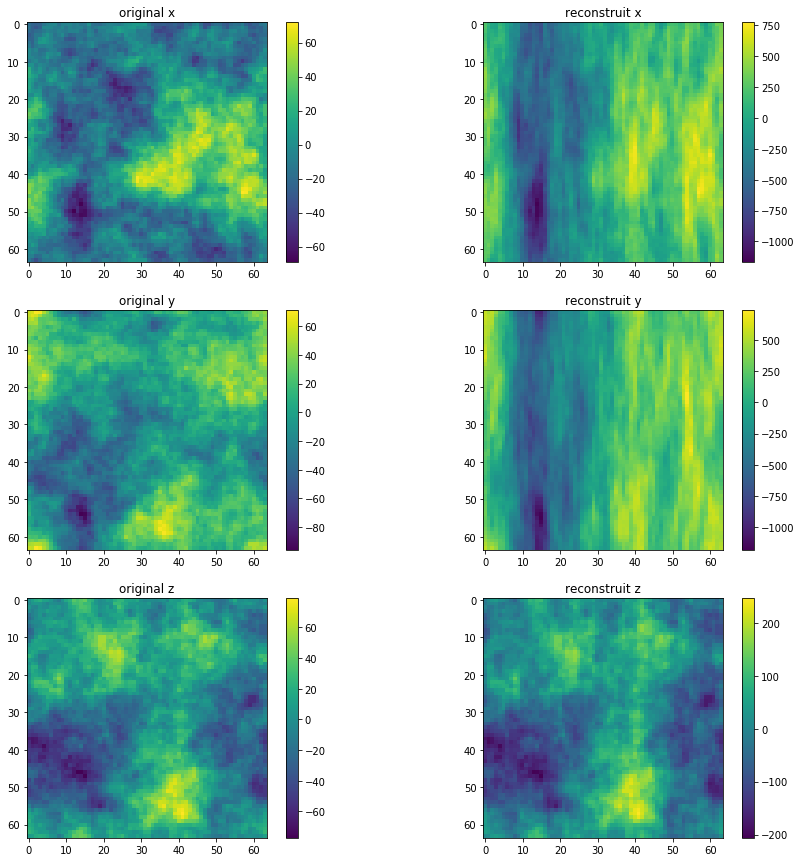

In [57]:
figure(figsize=(15,15))
sum_k_reco = np.sum(wt, axis = 0)

subplot(321)
orig = np.sum(fbm3d_turbu, axis = 0)
imshow(orig)
title("original x")
colorbar()

subplot(322)
tr = np.sum(sum_k_reco.real, axis = 0)
imshow(tr)
title("reconstruit x")
colorbar()

subplot(323)
orig = np.sum(fbm3d_turbu, axis = 1)
imshow(orig)
title("original y")
colorbar()

subplot(324)
tr = np.sum(sum_k_reco.real, axis = 1)
imshow(tr)
title("reconstruit y")
colorbar()

subplot(325)
orig = np.sum(fbm3d_turbu, axis = 2)
imshow(orig)
title("original z")
colorbar()

subplot(326)
tr = np.sum(sum_k_reco.real, axis = 2)
imshow(tr)
title("reconstruit z")
colorbar()

***
# Test de suppression des angles sur-echantillonnée
## représentation dans le plan UV

In [6]:
nx = 64
ny = 64
nz = 64

In [61]:
ko= 5.336
a = 25.

delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

uv_t = np.zeros((nx,ny,nz))

for i in trange(1,N) :
    t=float(delta*i)
    for j in range(N+1):
        
        ph=float(delta*j)
        uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
        uv_t= uv_t+ uv
        

ph = delta*N/2
t=0
uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
uv_t[:,:,:]= uv_t[:,:,:]+ uv


t=float(delta*(N))
uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
uv_t[:,:,:]= uv_t[:,:,:]+ uv

100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


Text(0.5, 1.0, '3')

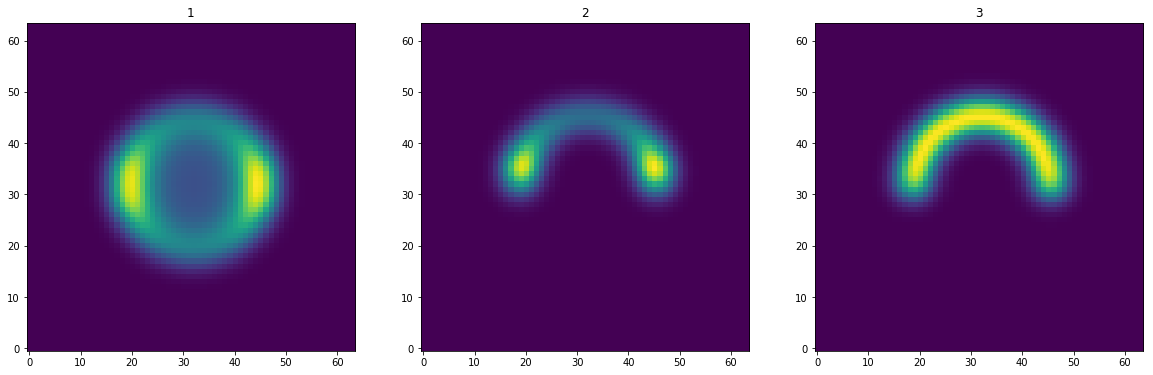

In [62]:
figure(figsize=(20,10))
subplot(131)
imshow(np.sum(uv_t, axis = 0),origin="lower")
title("1")

subplot(132)
imshow(uv_t[:,int(ny/2),:],origin="lower")
title("2")

subplot(133)
imshow(uv_t[:,:,int(nz/2)],origin="lower")
title("3")

## Reconstruction

In [83]:
nx = fbm3d_turbu.shape[0]
ny = fbm3d_turbu.shape[1]
nz = fbm3d_turbu.shape[2]
reso=1
fbm3d_turbu -= np.mean(fbm3d_turbu)
ko= 5.336
delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

#-----echelle a-----
nmax = np.max(np.array([nx,ny,nz]))
M=int(np.log(nmax)/delta)
a2=np.zeros(M)
a2[0]=np.log(nx)

for i in range(M-1):
    a2[i+1]=a2[i]-delta

a2=np.exp(a2)
wav_k = 1. / (a2 * reso)
a = ko * a2    #Scales in the wavelet space
#---------uv plane def
x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

#--------------------
wt = np.zeros((M,nx,ny,nz),dtype=complex)
uv_t2 = np.zeros((nx,ny,nz))

#--------------Wavelet transform----------------

imFT = np.fft.fftn(fbm3d_turbu)
imFT = np.fft.fftshift(imFT)

for k in trange(M) :
    for i in range(1,N) :
        t=float(delta*i)       
        for j in range(N+1):
            ph=float(delta*(j))
            uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
            W1FT = imFT * uv
            W1FT = np.fft.ifftshift(W1FT)
            W1 = np.fft.ifftn(W1FT)
            
            wt[k,:,:,:]= wt[k,:,:,:]+ W1
            
       
    ph = delta*N/2
    t=0
    uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
    W1FT = imFT * uv
    W1FT = np.fft.ifftshift(W1FT)
    W1 = np.fft.ifftn(W1FT)
    wt[k,:,:,:]= wt[k,:,:,:]+ W1
    
    
    t=float(delta*(N))
    uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
    W1FT = imFT * uv
    W1FT = np.fft.ifftshift(W1FT)
    W1 = np.fft.ifftn(W1FT)
    wt[k,:,:,:]= wt[k,:,:,:]+ W1


100%|██████████| 14/14 [01:04<00:00,  4.62s/it]


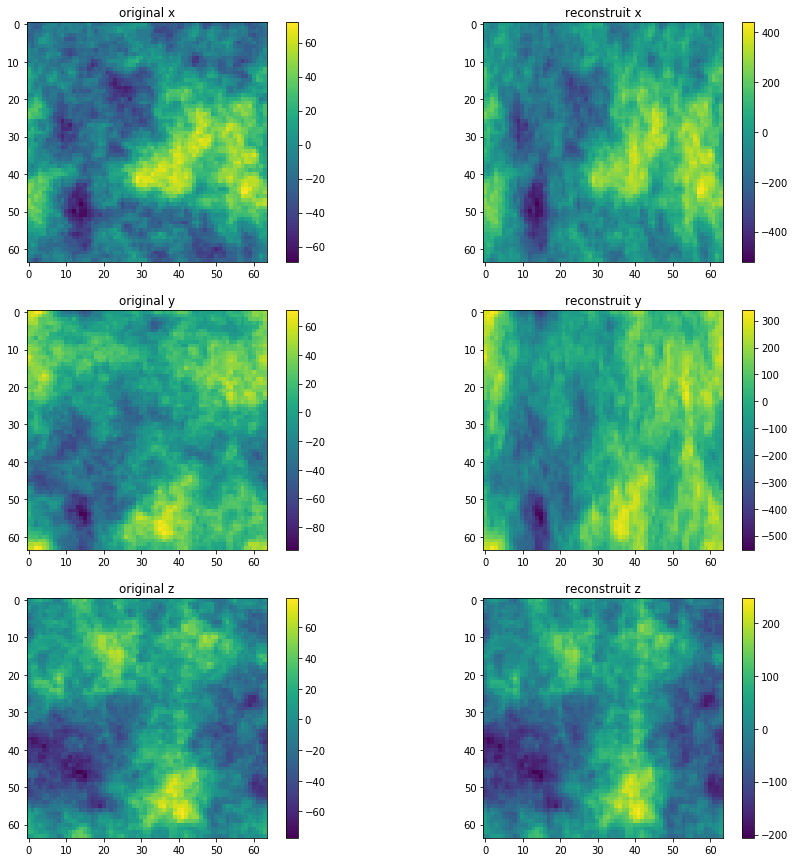

In [84]:
figure(figsize=(15,15))
sum_k_reco = np.sum(wt, axis = 0)

subplot(321)
orig = np.sum(fbm3d_turbu, axis = 0)
imshow(orig)
title("original x")
colorbar()

subplot(322)
tr = np.sum(sum_k_reco.real, axis = 0)
imshow(tr)
title("reconstruit x")
colorbar()

subplot(323)
orig = np.sum(fbm3d_turbu, axis = 1)
imshow(orig)
title("original y")
colorbar()

subplot(324)
tr = np.sum(sum_k_reco.real, axis = 1)
imshow(tr)
title("reconstruit y")
colorbar()

subplot(325)
orig = np.sum(fbm3d_turbu, axis = 2)
imshow(orig)
title("original z")
colorbar()

subplot(326)
tr = np.sum(sum_k_reco.real, axis = 2)
imshow(tr)
title("reconstruit z")
colorbar()

Reconstruction mieux que précédement mais pas encore satisfaisant.

***
# Test 2 de suppression des angles sur-echantillonnée
## représentation dans le plan UV

In [81]:
ko= 5.336
a = 25.

delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

uv_t = np.zeros((nx,ny,nz))

for i in trange(2,N-1) :
    t=float(delta*i)
    for j in range(N+1):
        
        ph=float(delta*j)
        uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
        uv_t= uv_t+ uv
        

ph = delta*N/2
t=0
uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
uv_t[:,:,:]= uv_t[:,:,:]+ uv

t=delta
uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
uv_t[:,:,:]= uv_t[:,:,:]+ uv


t=float(delta*(N))
uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
uv_t[:,:,:]= uv_t[:,:,:]+ uv

t=float(delta*(N-1))
uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2. + (a*z - ko*np.cos(t))**2.))
uv_t[:,:,:]= uv_t[:,:,:]+ uv

100%|██████████| 8/8 [00:00<00:00,  8.00it/s]


Text(0.5, 1.0, '3')

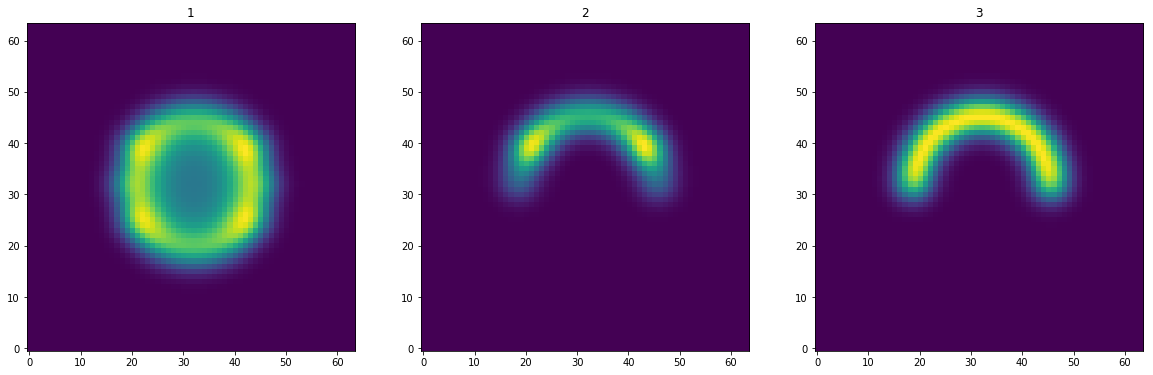

In [82]:
figure(figsize=(20,10))
subplot(131)
imshow(np.sum(uv_t, axis = 0),origin="lower")
title("1")

subplot(132)
imshow(uv_t[:,int(ny/2),:],origin="lower")
title("2")

subplot(133)
imshow(uv_t[:,:,int(nz/2)],origin="lower")
title("3")

## Reconstruction

In [85]:
nx = fbm3d_turbu.shape[0]
ny = fbm3d_turbu.shape[1]
nz = fbm3d_turbu.shape[2]
reso=1
fbm3d_turbu -= np.mean(fbm3d_turbu)
ko= 5.336
delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

#-----echelle a-----
nmax = np.max(np.array([nx,ny,nz]))
M=int(np.log(nmax)/delta)
a2=np.zeros(M)
a2[0]=np.log(nx)

for i in range(M-1):
    a2[i+1]=a2[i]-delta

a2=np.exp(a2)
wav_k = 1. / (a2 * reso)
a = ko * a2    #Scales in the wavelet space
#---------uv plane def
x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

#--------------------
wt = np.zeros((M,nx,ny,nz),dtype=complex)
uv_t2 = np.zeros((nx,ny,nz))

#--------------Wavelet transform----------------

imFT = np.fft.fftn(fbm3d_turbu)
imFT = np.fft.fftshift(imFT)

for k in trange(M) :
    for i in range(2,N-1) :
        t=float(delta*i)       
        for j in range(N+1):
            ph=float(delta*(j))
            uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
            W1FT = imFT * uv
            W1FT = np.fft.ifftshift(W1FT)
            W1 = np.fft.ifftn(W1FT)
            
            wt[k,:,:,:]= wt[k,:,:,:]+ W1
            
       
    ph = delta*N/2
    t=0
    uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
    W1FT = imFT * uv
    W1FT = np.fft.ifftshift(W1FT)
    W1 = np.fft.ifftn(W1FT)
    wt[k,:,:,:]= wt[k,:,:,:]+ W1
    
    t=delta
    uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
    W1FT = imFT * uv
    W1FT = np.fft.ifftshift(W1FT)
    W1 = np.fft.ifftn(W1FT)
    wt[k,:,:,:]= wt[k,:,:,:]+ W1
    
    
    t=float(delta*(N-1))
    uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
    W1FT = imFT * uv
    W1FT = np.fft.ifftshift(W1FT)
    W1 = np.fft.ifftn(W1FT)
    wt[k,:,:,:]= wt[k,:,:,:]+ W1
    
    t=float(delta*(N))
    uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2. + (a[k]*z - ko*np.cos(t))**2.))
    W1FT = imFT * uv
    W1FT = np.fft.ifftshift(W1FT)
    W1 = np.fft.ifftn(W1FT)
    wt[k,:,:,:]= wt[k,:,:,:]+ W1


100%|██████████| 14/14 [00:51<00:00,  3.71s/it]


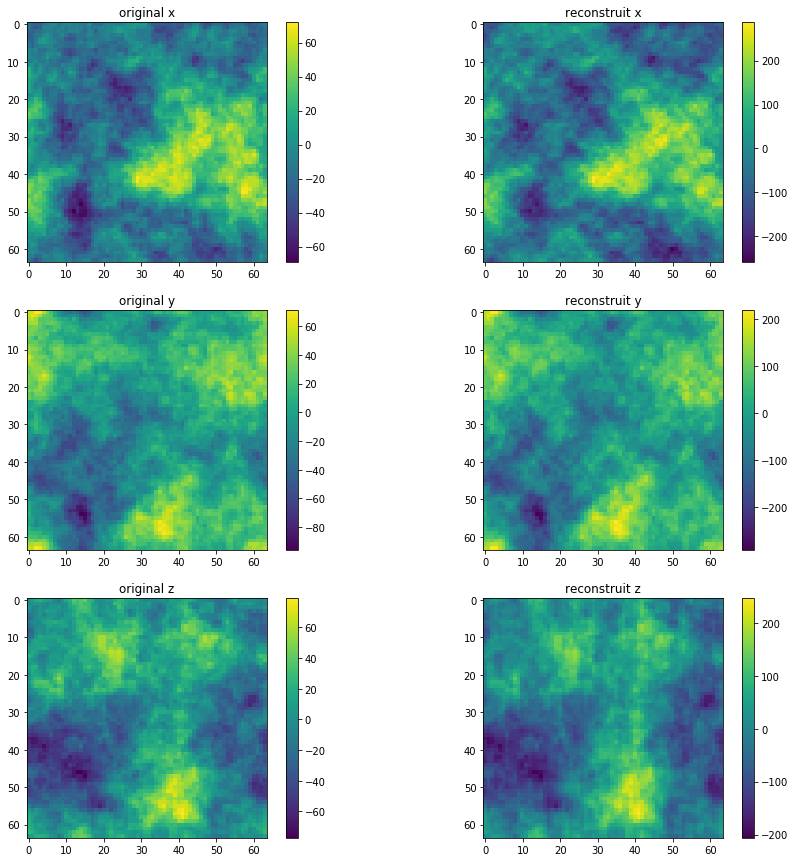

In [86]:
figure(figsize=(15,15))
sum_k_reco = np.sum(wt, axis = 0)

subplot(321)
orig = np.sum(fbm3d_turbu, axis = 0)
imshow(orig)
title("original x")
colorbar()

subplot(322)
tr = np.sum(sum_k_reco.real, axis = 0)
imshow(tr)
title("reconstruit x")
colorbar()

subplot(323)
orig = np.sum(fbm3d_turbu, axis = 1)
imshow(orig)
title("original y")
colorbar()

subplot(324)
tr = np.sum(sum_k_reco.real, axis = 1)
imshow(tr)
title("reconstruit y")
colorbar()

subplot(325)
orig = np.sum(fbm3d_turbu, axis = 2)
imshow(orig)
title("original z")
colorbar()

subplot(326)
tr = np.sum(sum_k_reco.real, axis = 2)
imshow(tr)
title("reconstruit z")
colorbar()

Reconstruction passable mais il reste encore quelque artefacts de calculs

***
# Suppression de la dependance en angle de la partie en z
## Représentation dans le plan UV

In [107]:
nx = 64
ny = 64
nz = 64

ko= 5.336
a = 25.

delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

uv_t = np.zeros((nx,ny,nz))

for i in trange(N+1) :
    t=float(delta*i)
    for j in range(N+1):
        
        ph=float(delta*j)
        #uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2.+(a*z-delta*p*np.cos(t))**2))
        uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2.+(a*z)**2))
        uv_t[:,:,:]= uv_t[:,:,:]+ uv


100%|██████████| 12/12 [00:01<00:00,  6.03it/s]


Text(0.5, 1.0, '3')

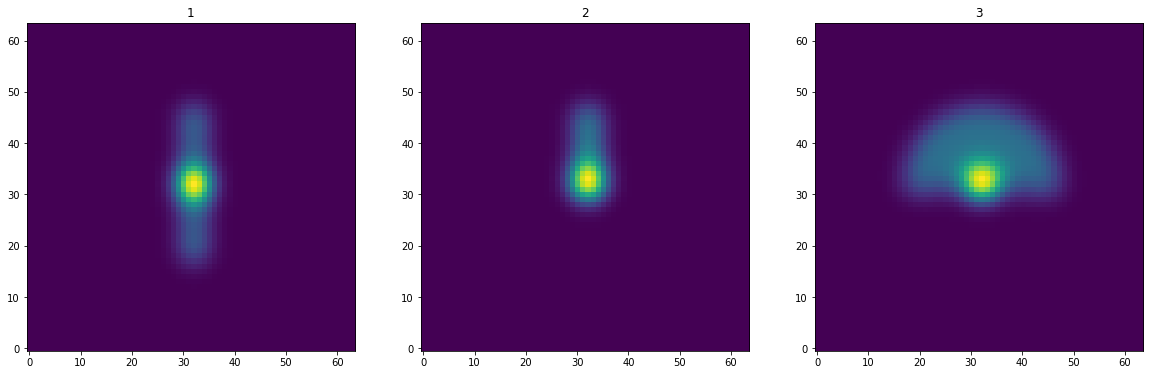

In [108]:
figure(figsize=(20,10))
subplot(131)
imshow(uv_t[int(nz/2),:,:],origin="lower")
title("1")

subplot(132)
imshow(uv_t[:,int(ny/2),:],origin="lower")
title("2")

subplot(133)
imshow(uv_t[:,:,int(nz/2)],origin="lower")
title("3")

## Reconstruction

In [105]:
nx = fbm3d_turbu.shape[0]
ny = fbm3d_turbu.shape[1]
nz = fbm3d_turbu.shape[2]
reso=1
ko= 5.336
delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
N = int(np.pi/delta)     #Number of orientation for the Morlet wavelet

#-----echelle a-----
nmax = np.max(np.array([nx,ny,nz]))
M=int(np.log(nmax)/delta)
a2=np.zeros(M)
a2[0]=np.log(nx)

for i in range(M-1):
    a2[i+1]=a2[i]-delta

a2=np.exp(a2)
wav_k = 1. / (a2 * reso)
a = ko * a2    #Scales in the wavelet space
#---------uv plane def
x=np.arange(nx)
y=np.arange(ny)
z=np.arange(nz)
x,y,z=np.meshgrid(x,y,z)

x = (1.*x - (nx)/2. )/ nx
y = (1.*y-(ny/2.))/ny
z = (1.*z-(nz/2.))/nz

#rr = (xx**2 + yy**2 + zz**2)**0.5

#--------------------
wt = np.zeros((M,nx,ny,nz),dtype=complex)
uv_t2 = np.zeros((nx,ny,nz))

#--------------Wavelet transform----------------

imFT = np.fft.fftn(fbm3d_turbu)
imFT = np.fft.fftshift(imFT)

for k in trange(M) :
    for i in range(N+1) :
        t=float(delta*i)
        for j in range(N+1):
            
            ph=float(delta*j)
            #uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2.+(a*z-delta*p*np.cos(t))**2))
            uv = np.exp( -.5*((a[k]*x - ko*np.sin(t)*np.cos(ph))**2. + (a[k]*y - ko*np.sin(t)*np.sin(ph))**2.+(a[k]*z)**2))
            #uv = np.exp( -.5*((a*x - ko*np.sin(t)*np.cos(ph))**2. + (a*y - ko*np.sin(t)*np.sin(ph))**2.))
            #print(uv_int.mean())
            #uv_t[:,:,:]= uv_t[:,:,:]+ uv
            W1FT = imFT * uv
            W1FT = np.fft.ifftshift(W1FT)
            W1 = np.fft.ifftn(W1FT)
                
            wt[k,:,:,:]= wt[k,:,:,:]+ W1
            
#np.save("/user/workdir/soldanof/3Dwavelet/wt.npy", wt)

100%|██████████| 14/14 [01:31<00:00,  6.51s/it]


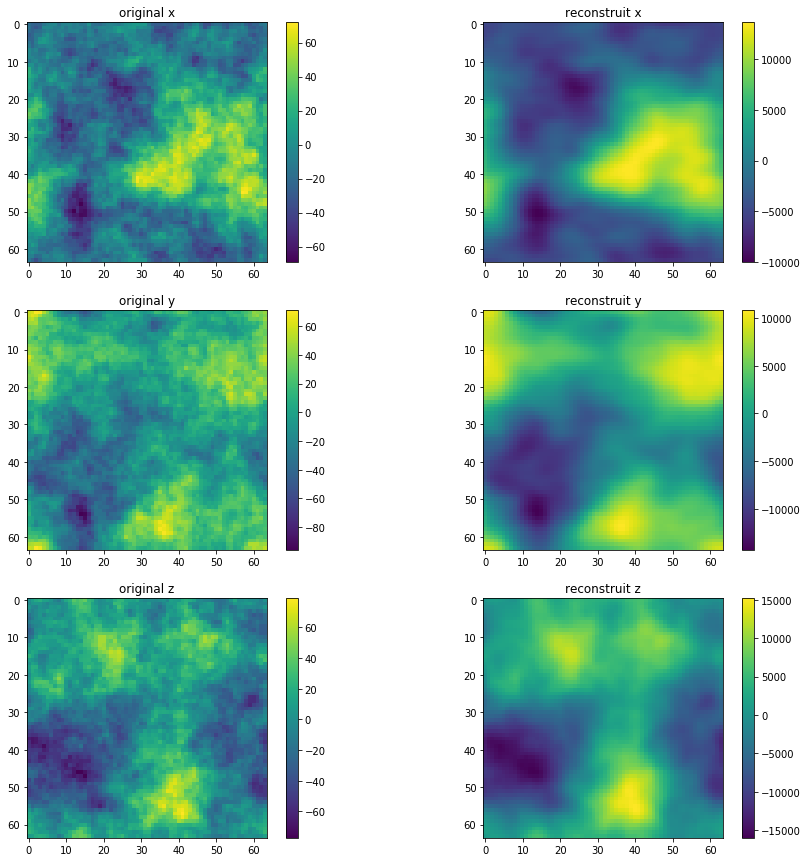

In [106]:
figure(figsize=(15,15))
sum_k_reco = np.sum(wt, axis = 0)

subplot(321)
orig = np.sum(fbm3d_turbu, axis = 0)
imshow(orig)
title("original x")
colorbar()

subplot(322)
tr = np.sum(sum_k_reco.real, axis = 0)
imshow(tr)
title("reconstruit x")
colorbar()

subplot(323)
orig = np.sum(fbm3d_turbu, axis = 1)
imshow(orig)
title("original y")
colorbar()

subplot(324)
tr = np.sum(sum_k_reco.real, axis = 1)
imshow(tr)
title("reconstruit y")
colorbar()

subplot(325)
orig = np.sum(fbm3d_turbu, axis = 2)
imshow(orig)
title("original z")
colorbar()

subplot(326)
tr = np.sum(sum_k_reco.real, axis = 2)
imshow(tr)
title("reconstruit z")
colorbar()

Reconstruction ok sur les grandes échelles mais pas sur les petites. Au vue des valeurs il semble y avoir encore du sur-échantilonnage.    
Ceci montre donc que la forme première imaginé peut être bonne dans une certaine mesure.

***
# Idée : nouvelle forme d'ondelette
(pas assez de temps durans ce stage pour réaliser cette idée)  

Construction plan par plan de l'ondelette 3D sous forme de demi-sphère

In [ ]:
uv=np.exp( -.5*((a[j]*x - ko*np.cos(t))**2. + (a[j]*y - ko*np.sin(t))**2.))

$R(z)=r^2-z^2$